In [1]:
# Fill in your name using the format below and student ID number
your_name = "van den Brandt, Irma"
student_id = "1081110"


In [2]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True


In [3]:
# Uncomment the following line to run in Google Colab
# !pip install --quiet openml 

In [4]:
# Uncomment the following line to run in Google Colab
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available


[]

In [5]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn


In [6]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))
    

Hi Irma, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [7]:
#base_dir = '/content/drive/My Drive/TestAssignment' # For Google Colab
base_dir = '/Users/IrmavandenBrandt/Downloads/WIR/assignment-3-irmavdbrandt-master'

In [8]:
#Uncomment to link Colab notebook to Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [9]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
#import os
#oml.config.cache_directory = os.path.expanduser('/content/cache')

In [10]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

Reshape, sample and split the data

In [11]:
from tensorflow.keras.utils import to_categorical

Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)

In [12]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.
from sklearn.model_selection import train_test_split
# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

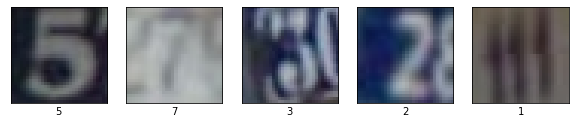

In [13]:
from random import randint

# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [14]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow
from tensorflow.keras.models import model_from_json


def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')


def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
        base_dir -- Directory where the models are stored
        name -- Name of the model, e.g. 'question_1_1'
        extension -- the file extension
    """
    try:
        # if a json description is available, load config and then weights
        if os.path.isfile(os.path.join(base_dir, name+'.json')):
            json_file = open(os.path.join(base_dir, name+'.json'), 'r')
            loaded_model_json = json_file.read()
            json_file.close()
            model = model_from_json(loaded_model_json)
            model.load_weights(os.path.join(base_dir, name+extension))
            # else just load the entire model from hdf5 file
        else:
            model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model


def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
        model -- the model to be saved
        base_dir -- Directory where the models should be stored
        name -- Name of the model, e.g. 'question_1_1'
        extension -- the file extension
    """
    path = os.path.join(base_dir, name+extension)
    model.save(path)
    size = os.path.getsize(path)
    # If model > 100MB, store the weights and architecture only.
    if size > 100*1024*1024:
        print("Model larger than 100MB, storing weights only.")
        model.save_weights(path)
        model_json = model.to_json()
        with open(os.path.join(base_dir, name+".json"), "w") as json_file:
            json_file.write(model_json)

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233229  0.190608  2.233081      0.190974
max  2.245158  0.190954  2.233173      0.190974


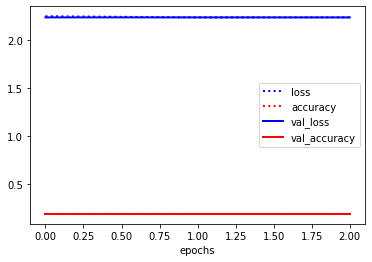

In [15]:
# Toy usage example
# Remove before submission
from tensorflow.keras import models
from tensorflow.keras import layers 

def build_toy_model():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))
    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# First build and store
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=True, epochs=3, batch_size=32)

Loading model from file
Success!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                30730     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  2.233229  0.190608  2.233081      0.190974
max  2.245158  0.190954  2.233173      0.190974


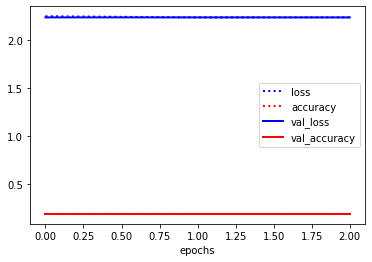

In [16]:
# Toy usage example
# Remove before submission
# With train=False: load from file and report the same results without rerunning
run_evaluation("toy_example", build_toy_model, evaluation_split, base_dir, 
               train=False)

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

In [17]:
from tensorflow.keras import models
from tensorflow.keras import layers 
from tensorflow.keras import optimizers

Loading model from file
Success!
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 3072)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              3146752   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 3,837,066
Trainable params: 3,837,066
Non-trainable params: 0
___________

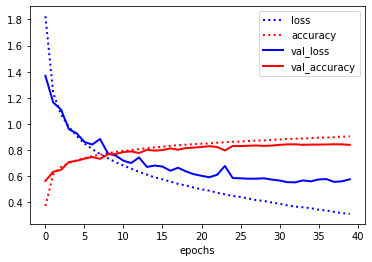

In [18]:
def build_model_1_1():
    model = models.Sequential()
    model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.00001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    adam = optimizers.Adam(learning_rate=0.00005) #works best
    adagrad = optimizers.Adagrad(learning_rate=0.00005) #similar to adam but slightly worse

    model.compile(optimizer=adam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    
    return model 

run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
               train=True, epochs=40, batch_size=32)

answer_q_1_1 = """ Multiple hidden layers are used, research showed this works well in case of recognizing difficult 
objects. Optimizer Adam is optimal in most cases because its combination of the RMSprop and Adagrad properties. 
Adagrad's performance was similar to Adam's but slightly worse. The default learning rate resulted in a 
bad performance (+/- 0.58), the current seemed optimal during testing. The model overfits but performs quite well
on the validation set. The accuracy stabilizes around 40 epochs. """


# print("Answer is {} characters long".format(len(answer_q_1_1)))




### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [19]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

In [20]:
# Apply standardization with the mean of the training set --> model overfits!! 
def standardize(X_train, X_val):
    mean = np.mean(X_train, axis=0)
    
    X_train_sta = (X_train - mean)/np.std(X_train, axis = 0)
    X_val_sta = (X_val - mean)/np.std(X_val, axis = 0)

    return X_train_sta, X_val_sta

In [21]:
# Replace with the preprocessed data
X_train_pre = rgb2gray(X_train)
X_val_pre = rgb2gray(X_val)

# Standardize 
X_train_sta, X_val_sta = standardize(X_train_pre, X_val_pre)

preprocessed_split = X_train_sta, X_val_sta, y_train, y_val



Loading model from file
Success!
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 1,739,914
Trainable params: 1,739,914
Non-trainable params: 0
___________

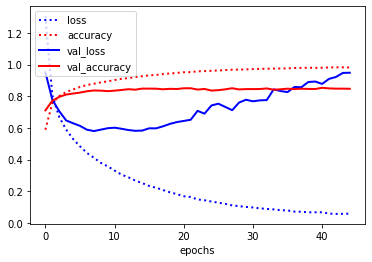

In [22]:
# Adjusted model
def build_model_1_2():
    model = models.Sequential()
    model.add(layers.Reshape((1024,), input_shape=(32,32,1)))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=optimizers.Adam(learning_rate=0.00005),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model 
    
# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=45, batch_size=32)

answer_q_1_2 = """
                Preprocessing the images with the greyscaling function does not seem to boost the performance of the model.         
                The model gives back similar results as before, the accuracy is just a tiny bit higher.
               Using standardization as extra preprocessing step, the model is boosted but is also overfitting very heavily
               on the training set (there is a large difference between the accuracy and validation accuracy). 
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

In [23]:
from tensorflow.keras.layers import Activation
from tensorflow.keras import regularizers

Loading model from file
Success!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
activation (Activation)      (None, 1024)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)               524800    
_________________________________________________________________
batch_normalization_1

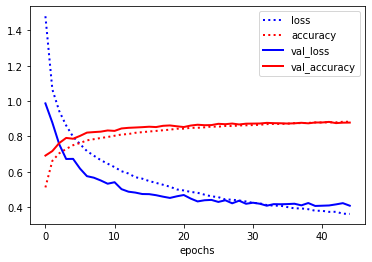

In [24]:
def build_model_1_3():
    drop_model = models.Sequential()
    drop_model.add(layers.Reshape((1024,), input_shape=(32,32,1)))

    drop_model.add(layers.Dense(1024))
    drop_model.add(layers.BatchNormalization())
    drop_model.add(Activation('relu'))
    drop_model.add(layers.Dropout(0.2))

    drop_model.add(layers.Dense(512))
    drop_model.add(layers.BatchNormalization())
    drop_model.add(Activation('relu'))
    drop_model.add(layers.Dropout(0.2))

    drop_model.add(layers.Dense(256))
    drop_model.add(layers.BatchNormalization())
    drop_model.add(Activation('relu'))
    drop_model.add(layers.Dropout(0.2))

    drop_model.add(layers.Dense(128))
    drop_model.add(layers.BatchNormalization())
    drop_model.add(Activation('relu'))
    drop_model.add(layers.Dropout(0.2))

    drop_model.add(layers.Dense(10, activation='softmax'))

    drop_model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        
    return drop_model 


run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=45, batch_size=48)

answer_q_1_3 = """Using drop-out layers with rate 0.2 is optimal (not too many nodes are left out), but the model is still overfitting. Combined with normalization enough noise is added to increase accuracy and regularize simultaneously. Normalized outputs create more stable activations, so the learning rate is boosted to 0.001. Larger batch-sizes decrease generalization, but due to underfitting the size is increased to 48. 
The train and validation accuracy are very close. Around 35 epochs overfitting starts."""

print("Answer is {} characters long".format(len(answer_q_1_3)))


## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Loading model from file
Success!
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)    

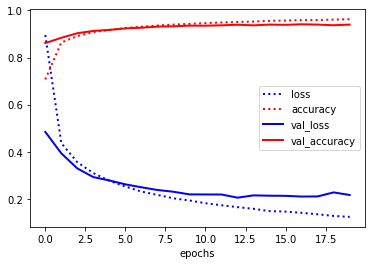

In [25]:
def build_model_2_1():

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 1)))
    
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2))) 
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2))) 
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.2))
    model.add(layers.MaxPooling2D((2, 2))) 
    
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(96, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0003),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model


run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=20, batch_size=32)

answer_q_2_1 = """First comes a conv layer with 32 nodes. Two alike blocks, the second one has more nodes (32 vs. 64), and a small block with conv layer 
and 64 nodes follow. Local features are learned first (less nodes needed) and complex, global features later (more nodes needed). A flatten, drop-out and 3 dense 
layers follow, inspired by the VGG-model. The first 2 dense layers consist of 96 and 128 nodes, more induce overfitting. The paddings handle different dimensions, 
the max-pool layers stop overfitting. Drop-out (rate 0.2) and batch normalization add regularization. The batch size is 128 to avoid underfitting. To not get stuck
in local minima, the learning rate is 0.0003. The model is overfitting: difference around 2 in train and validation accuracy. The model overfits heavily after 20 epochs.  
"""

print("Answer is {} characters long".format(len(answer_q_2_1)))


### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

In [26]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, shutil 

datagen_train = ImageDataGenerator(
      rotation_range=10,   
      width_shift_range=0.1,   
      height_shift_range=0.1,  
      shear_range=0.1, 
      zoom_range=0.1, 
      fill_mode='nearest'
)

train_generator = datagen_train.flow(
        X_train_sta,
        y_train,
        batch_size=128,
)


Loading model from file
Success!
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)    

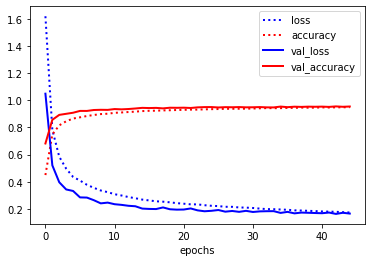

In [27]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data

import math

# NOTE: use steps_per_epoch = X_train.shape[0] / batch_size 
steps_per_epoch = math.ceil(X_train.shape[0]/128)  # len(x_train_sta)/batch_size

augmented_split = train_generator, X_val_sta, y_val
run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
               train=True, generator=True, epochs=45, steps_per_epoch=steps_per_epoch, batch_size=None)

answer_q_2_2 = """Rotations with range 10 are optimal and stop overfitting, higher ranges cause underfitting. Shifts with range 0.1 are optimal. Higher values 
cause digits located to a side to become partly invisible. Range 0.2 for zoom and shear is best, higher values cause some digits to become unrecognizable. 
Flips are unwanted. Batch size is 128 and number of epochs 45 to stop underfitting. The validation accuracy increases, the training one 
decreases, data augmentation has solved overfitting."""

print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

19858/19858 [==============================] - 13s 637us/sample - loss: 0.1713 - accuracy: 0.9523
Answer is 496 characters long


/Users/IrmavandenBrandt/anaconda3/envs/WIR/lib/python3.6/site-packages/ipykernel_launcher.py:32: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/IrmavandenBrandt/anaconda3/envs/WIR/lib/python3.6/site-packages/ipykernel_launcher.py:58: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


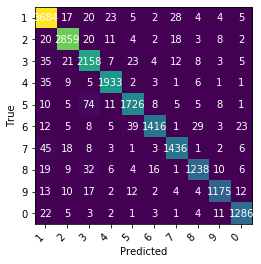

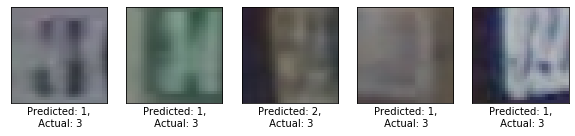

In [28]:
from sklearn.metrics import confusion_matrix

# preprocess test data
X_test_pre = rgb2gray(X_test)
X_train_v2, X_test_sta = standardize(X_train_pre, X_test_pre)




model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
test_loss, test_acc = model.evaluate(X_test_sta, y_test)  # also convert these to gray?

test_accuracy_3_1 = test_acc

# create predictions and a list of all unique classification labels
y_pred = model.predict(X_test_sta)  
classes = {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 0: '10'}

def plot_confusion_matrix():
    
    cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
    conf_fig, ax = plt.subplots()
    im = ax.imshow(cm)
    ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
    ax.set_xticklabels(list(classes), rotation=45, ha="right")
    ax.set_yticklabels(list(classes))
    ax.set_ylabel('True')
    ax.set_xlabel('Predicted')
    for i in range(100):
        ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")
        
    conf_fig.show()
        
plot_confusion_matrix()


def plot_misclassifications():  
    # Focus on class with label = 3 
    
    # find indices in y_test where the label is 3 (second element in arrays bc label is index+1)
    y_test_class3 = np.nonzero(np.take(y_test, 2, axis=1))
    
    # Find all misclassifications
    misclassified_samples = np.nonzero(np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1))[0]
    
    # Find misclassifications of class 3 using the indices in y_test_class3
    misclassifications_class3 = np.intersect1d(y_test_class3, misclassified_samples)
    
    
    miss_fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
    for nr, i in enumerate(misclassifications_class3[:5]):
        axes[nr].imshow(X_test[i])
        axes[nr].set_xlabel("Predicted: %s,\n Actual: %s" % (classes[(np.argmax(y_pred[i])+1)%10],classes[(np.argmax(y_test[i])+1)%10]))  # Label is index+1
        axes[nr].set_xticks(()), axes[nr].set_yticks(())
        
        

    miss_fig.show()

plot_misclassifications()


answer_q_3_1 = """The confusion matrix show the model often confuses 1 with other labels, especially with 6. The same holds vice versa. Also, 6 is often confused
with 5, 1 with 7 and 6 with 8. The errors made for class 3 are related to noise, the images below are very vague. The predicted labels are mostly wrong because 
the pixels that together resemble the predicted label are more clear than the others, in the first image the right part of the 3 is more clear and looks like a 
vertical line (i.e. label 1). """ 

print("Answer is {} characters long".format(len(answer_q_3_1)))

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [29]:
# Check the summary of the model to find which layers are of interest
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
batch_normalization_7 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 64)       

In [30]:
from tensorflow.keras.preprocessing import image

# We preprocess the first image of the test set to a tensor
img = X_test_sta[0]
img_tensor2 = image.img_to_array(img)
img_tensor2 = np.expand_dims(img_tensor2, axis=0) 

# Get output of first 8 layers
layer_outputs = [layer.output for layer in model.layers[:15]]
# Make model that gives output of layers based on input
act_model = models.Model(inputs=model.input, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations2 = act_model.predict(img_tensor2)

# Set the total images per row to be 16
images_per_row = 16

# Retrieve the names of the layers
layer_names = []
for layer in model.layers[:20]:
    layer_names.append(layer.name)

    
def plot_activations_exe_function(layer_index, activations):
    start = layer_index
    end = layer_index+1
    
    # Display feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
    
def plot_activations():
    # Use the plot_activations_exe_function to create the plots
    plot_activations_exe_function(0, activations2) # input layer
    plot_activations_exe_function(1, activations2) # second conv layer (32 nodes)
    plot_activations_exe_function(3, activations2) # third conv layer (32 nodes)
    plot_activations_exe_function(6, activations2) # fourth conv layer (64 nodes)
    plot_activations_exe_function(8, activations2) # fourth conv layer (64 nodes)
    plot_activations_exe_function(11, activations2) # fourth conv layer (64 nodes)
  

answer_q_3_2 = """The activation plots of the firsts two conv layers show the model first learns some local 
features such as the edges of the 8. The third conv layer is used to detect the inner areas of the digit, such as how 
large the width or length of certain areas is. It becomes much harder to recognize an 8. In the fourth conv layer the 
digit is not recognizable, the model focuses more on the whole image (also the background), i.e. the global
features. This increases in the concluding two layers."""
print("Answer is {} characters long".format(len(answer_q_3_2)))



Answer is 491 characters long


### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

In [31]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import cv2



Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


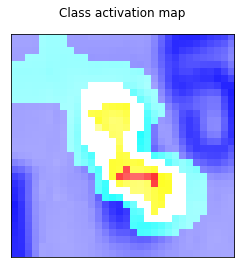

In [32]:

tf.compat.v1.disable_eager_execution()

# take first example of test set and prepare for function
img = X_test_sta[0]  

# img_tensor = np.copy(X_test_sta[0])
img_tensor = np.expand_dims(img, axis=0) 

model = load_model_from_file(base_dir, 'model_2_2', extension='.h5')
class8_output = model.output[:, 7]

def plot_3_3():
    last_conv_layer = model.get_layer('conv2d_11')
    grads = K.gradients(class8_output, last_conv_layer.output)[0]
    pooled_grads = K.mean(grads, axis=(0, 1, 2))

    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([img_tensor])

    for i in range(len(pooled_grads_value)):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)

    # Load the original image in grey scale
    img = X_test_pre[0]

    # Resizing of heatmap to size original image and converting to greyscale 
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)

    # We apply the heatmap to the original image
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.4 + img
    
    # Convert to float 32
    img_conv = superimposed_img.astype('float32')

    RGB_im = cv2.cvtColor(img_conv, cv2.COLOR_BGR2RGB)
    plt.rcParams['figure.dpi'] = 120
    plt.imshow(RGB_im)
    plt.title('Class activation map')
    plt.xticks([])         
    plt.yticks([])
    plt.show()
    
plot_3_3()

In [33]:
np.shape(img_tensor)

(1, 32, 32, 1)

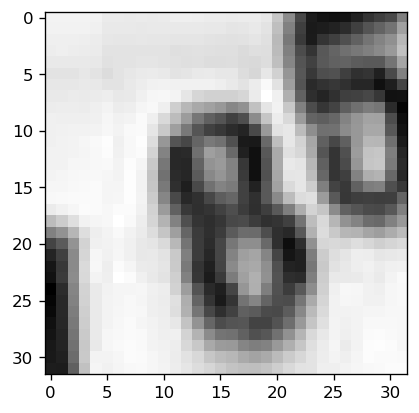

In [34]:
# Original image in grey scale
plt.imshow(np.copy(X_test_pre[0].squeeze()), cmap='gray')

## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Loading model from file
Success!
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D

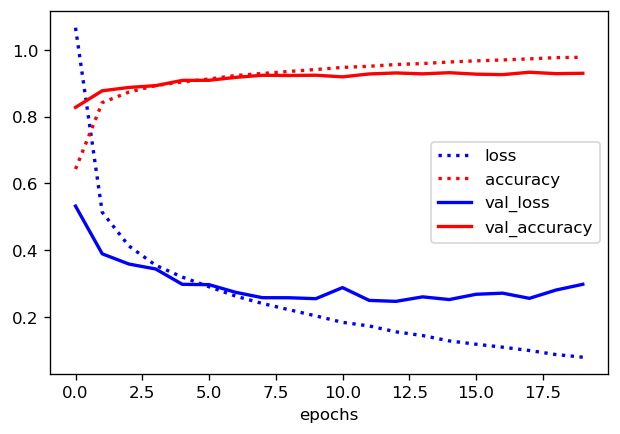

In [35]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

def build_model_4_1():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
    VGG_model = conv_base.output
    VGG_model = layers.Flatten()(VGG_model)
    VGG_model = layers.Dropout(0.2, name='dropout_first')(VGG_model)
    VGG_model = layers.Dense(128, activation='relu', name='dense_128')(VGG_model)
    VGG_model = layers.Dropout(0.2, name='dropout_second')(VGG_model)
    predictions = layers.Dense(10, activation='softmax', name='dense_10_class')(VGG_model)

    # trainig model
    model = models.Model(inputs=conv_base.input, outputs=predictions)

    # Setting the number of layers that are freezed
    for index, layer in enumerate(model.layers):
        if index < 7:  
            layer.trainable = False
        else:
            layer.trainable = True

    model.compile(optimizers.Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model


run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=128)

answer_q_4_1 = """Unfreezing only block 5, using 40 epochs, batch size of 64 and learning rate of 0.00002 gives the suboptimal 
results but less overfitting. Freezing the first 2-3 blocks of the conv base and using a learning rate of 0.001, the model overfits 
quickly and the validation accuracy is moderate. Using a lower learning rate (0.000001), the model does not learn enough and 
is stuck at a sub-optimal accuracy (0.75). Using a slightly higher learning rate (0.00001) gives the best results in accuracies."""

print("Answer is {} characters long".format(len(answer_q_4_1)))


### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [36]:
import pickle
import gzip
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline


def store_embedding(X, name):  
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
        pickle.dump(X, file_pi)

def load_embedding(name):
    with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
        return pickle.load(file_pi)

def store_embeddings(X_train, X_test):
    # load model 4.1 and the output of the maxpool layer after the last conv layer
    # model = load_model_from_file(base_dir, 'model_4_1')
    model = load_model_from_file(base_dir, 'model_4_1')
    model_output = model.get_layer('block5_pool').output
    conv_base = models.Model(inputs=model.input, outputs=model_output)
    
    sample_count_train = X_train.shape[0]
    sample_count_test = X_test.shape[0]

    features_train = np.zeros(shape=(sample_count_train, 1, 1, 512))
    features_test = np.zeros(shape=(sample_count_test, 1, 1, 512))
    
    # Set the batch size to 128
    batch_size=128
    
    # Generate image data generator for both sets
    generator_embed_train = tf.keras.preprocessing.image.NumpyArrayIterator(
        X_train, 
        y=y_train, 
        image_data_generator=ImageDataGenerator(), 
        batch_size=batch_size)
    
    generator_embed_test = tf.keras.preprocessing.image.NumpyArrayIterator(
        X_test, 
        y=y_test, 
        image_data_generator=ImageDataGenerator(), 
        batch_size=batch_size)
    
    i = 0
    for inputs_batch, labels_batch in generator_embed_train:
        features_batch = conv_base.predict(inputs_batch)
        features_train[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count_train:
            break
    
    i = 0
    for inputs_batch, labels_batch in generator_embed_test:
        features_batch = conv_base.predict(inputs_batch)
        features_test[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count_test:
            break
            
    # Reshape the feature embeddings to one dimension to be able to use them to classify
    features_train = np.reshape(features_train, (features_train.shape[0], 1 * 1 * 512))
    features_test = np.reshape(features_test, (features_test.shape[0], 1 * 1 * 512))
            
    return store_embedding(features_train, 'train_embed'), store_embedding(features_test, 'test_embed')

def generate_pipeline():
    """ Returns an sklearn pipeline.
      """
    # Choose either one
    # RF_clf = RandomForestClassifier(max_depth=20, n_estimators=1000, verbose=1, random_state=0)
    KNN_clf = KNeighborsClassifier(n_neighbors=15, n_jobs=-1)
    
    return Pipeline(steps=[('classifier', KNN_clf)])

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
    """ Evaluates the given pipeline, trained on the given embedded training set and 
          evaluated on the supplied embedded test set. Returns the accuracy score.
     """
    trained_pipe = pipeline.fit(X_train, np.argmax(y_train, axis=1))
    test_accuracy = trained_pipe.score(X_test, np.argmax(y_test, axis=1))
    
    return test_accuracy

def evaluation_4_2(X_train, y_train, X_test, y_test):
    """ Runs 'evaluate_pipeline' with embedded versions of the input data 
     and returns the accuracy.
      """
    return evaluate_pipeline(generate_pipeline(), load_embedding('train_embed'), y_train, load_embedding('test_embed'), y_test)

answer_q_4_2 = """The convolutional base used to create embeddings is trained so that the last 3 conv blocks are unfreezed. 
The two classifiers used in this exercise (KNN and RF) show that the model performs very good with the embeddings. 
Both classifiers obtain an accuracy of +/- 0.932. The best model so far (Q2.2) is not beaten, but it is a close."""

print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

Pipeline: Pipeline(memory=None,
         steps=[('classifier',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=15, p=2,
                                      weights='uniform'))],
         verbose=False)
Answer is 335 characters long


In [38]:
train_embeddings = load_embedding('train_embed')
test_embeddings = load_embedding('test_embed')

In [39]:
evaluation_4_2(X_train, y_train, X_test, y_test)

0.9317655353006346